# run hapBLOCK on diploid gt vcf

In [1]:
import sys
sys.path.append('/mnt/archgen/users/yilei/tools/ancIBD/python3')
from IO.h5_modify import merge_in_af, get_af, get_af1000G, lift_af, save_h5, get_af1000G_atGivenPos

In [2]:
import numpy as np
import h5py
import pandas as pd

def merge_in_ld_map(path_h5, path_snp1240k, chs=range(1,23), write_mode="a"):
    """Merge in MAP from eigenstrat .snp file into
    hdf5 file. Save modified h5 in place 
    path_h5: Path to hdf5 file to modify.
    path_snp1240k: Path to Eigenstrat .snp file whose map to use
    chs: Which Chromosomes to merge in HDF5 [list].
    write_mode: Which mode to use on hdf5. a: New field. r+: Change Field"""
    with h5py.File(path_h5, "r") as f:
        print("Lifting LD Map from eigenstrat to HDF5...")
        print("Loaded %i variants." % np.shape(f["calldata/GT"])[0])
        print("Loaded %i individuals." % np.shape(f["calldata/GT"])[1])

        ### Load Eigenstrat
        df_snp = pd.read_csv(path_snp1240k, header=None, sep=r"\s+", engine="python")
        df_snp.columns = ["SNP", "chr", "map", "pos", "ref", "alt"]

        rec = np.zeros(len(f["variants/POS"]))  # Create the array for vector

        for ch in chs:
            df_t = df_snp[df_snp["chr"] == ch]
            print(f"Loaded {len(df_t)} Chr.{ch} 1240K SNPs.")

            idx_f = f["variants/CHROM"][:].astype("str")==str(ch)
            if np.sum(idx_f)==0:  # If no markers found jump to next chromosome
                print("Did not find any markers...")
                continue
            rec_ch = np.zeros(len(idx_f), dtype="float")

            ### Intersect SNP positions
            its, i1, i2 = np.intersect1d(f["variants/POS"][idx_f], df_t["pos"], return_indices=True)

            l = np.sum(idx_f)
            print(f"Intersection {len(i2)} out of {l} HDF5 SNPs")

            ### Extract Map positions
            rec_ch[i1] = df_t["map"].values[i2]  # Fill in the values in Recombination map

            ### Interpolate if Needed (map position still 0)
            itp_idx = (rec_ch == 0)
            if np.sum(itp_idx) > 0:   # In case we have to interpolate
                print(f"Interpolating {np.sum(itp_idx)} variants.")
                x = df_t["pos"] 
                y = df_t["map"]   
                x1 = f["variants/POS"][:][idx_f]  # Extract all positions of interest
                assert(np.all(np.diff(x) > 0))
                rec_ch = np.interp(x1, x, y)

            
            ### Make sure that sorted
            assert(np.all(np.diff(rec_ch)>=0))  # Assert the Recombination Map is sorted! (no 0 left and no funky stuff)
            rec[idx_f]=rec_ch # Set the Map position for chromosome indices
            print(f"Finished Chromosome {ch}.")
    
    ### Now create the new column in hdf5
    print("Adding map to HDF5...")
    with h5py.File(path_h5, write_mode) as f0:
        group = f0["variants"]
        l = len(f0["variants/POS"])
        if write_mode == "a":  # If appending new data
            group.create_dataset('MAP', (l,), dtype='f')   
        f0["variants/MAP"][:] = rec[:]
    print("We did it. Finished.")

import allel
def vcf_to_1240K_hdf(in_vcf_path = "/n/groups/reich/ali/WholeGenomeImputation/imputed/v43.4/chr3.bcf",
                     path_vcf = "./data/vcf/1240k_v43/ch3.vcf.gz",
                     path_h5 = "./data/hdf5/1240k_v43/ch3.h5",
                     map_path="/n/groups/reich/DAVID/V43/V43.5/v43.5.snp",
                     ch=3):
    """Convert Ali's vcf to 1240K hdf5. 
    If marker_path empty, no SNP filtering done.
    If map_path empty, no genetic map is merged in.
    """ 
    path_vcf = in_vcf_path # Use the unfiltered input in next step
    
    allel.vcf_to_hdf5(input=path_vcf, output=path_h5, 
                  fields = ['variants/*', 'calldata/*', "samples"], compression="gzip") # Do the conversion to hdf5. Takes hours
    print("Finished conversion to hdf5!")
    
    if len(map_path)>0:
        merge_in_ld_map(path_h5=path_h5, 
                    path_snp1240k=map_path,
                    chs=[ch])

In [16]:
    
in_vcf_path = "AGDP.ch3.GP99.MAF5.tvOnly.vcf.gz"
path_h5 = "AGDP.ch3.MAF5.tvOnly.h5"
map_path = '/mnt/archgen/users/yilei/bin/ancIBD_data/afs/v51.1_1240k.snp'
    
vcf_to_1240K_hdf(in_vcf_path = in_vcf_path, path_vcf = "", path_h5=path_h5,
                map_path = map_path, ch=3)




Finished conversion to hdf5!
Lifting LD Map from eigenstrat to HDF5...
Loaded 125299 variants.
Loaded 52 individuals.
Loaded 81416 Chr.3 1240K SNPs.
Intersection 11234 out of 125299 HDF5 SNPs
Interpolating 114065 variants.
Finished Chromosome 3.
Adding map to HDF5...
We did it. Finished.


# visualize 

In [1]:
import matplotlib.pyplot as plt

def plot_hets(ax, het_m, het, alpha=0.3, ms=1, het_c="slateblue",
              ylabel = "Opp. Homozygotes (no/yes)", fs_l=12, ylim=[]):
    """Plot Heterozygote Markers onto Axis"""
    ax2 = ax.twinx()
    ax2.plot(het_m*100, (het * 1.1 - 0.05), "o", ms=ms, alpha=alpha, zorder=0, color=het_c)
    ax2.set_yticks([-0.05, 1.05])
    ax2.set_yticklabels([])
    ax2.set_ylabel(ylabel, fontsize=fs_l, color=het_c)
    if len(ylim)>0:
        ax2.set_ylim(ylim)


def plot_posterior(ax=0, morgan=[], het=[], het_m=[], 
                   df_ibd=None, state=0, figsize=(12,3), 
                   xlim=[], ylim=[-0.08,1.27], ylabel="Posterior", xlabel="Position",
                   c="maroon", het_c="gray", c_truth="green", ms=1,
                   lw=3, lw_ibd=10, c_ibd="slateblue", y_ibd=1.2, dpi=400, 
                   fs_l=12, show=True, min_cm=4, title="", savepath=""):
    """Plot Posterior [k,l] array. If morgan given, plot in centimorgan.
    Can then also plot hapROH formatted IBD blocks (df_ibd).
    And plot ground truth hapROH formatted IBD blocks (df_truth).
    If het is given [array boolean], plot het using het_m coordinates"""
    if ax==0:
        plt.figure(figsize=figsize)
        ax=plt.gca()
    #ax.plot(morgan*100, post[state,:], color=c, lw=lw)
    ax.set_yticks([0., 0.2, 0.4, 0.6, 0.8, 1.0])
    ### Do optional plotting
    # Hets
    if len(xlabel)>0:
        ax.set_xlabel(xlabel, fontsize=fs_l)
    if len(ylabel)>0:
        ax.set_ylabel(ylabel, fontsize=fs_l)
    if len(xlim)>0:
        ax.set_xlim(xlim)
    if len(ylim)>0:
        ax.set_ylim(ylim)
    if len(het)>0:
        plot_hets(ax, het_m, het, ms=ms, het_c=het_c, fs_l=fs_l, ylim=ylim)
    if len(title)>0:
        ax.set_title(title, fontsize=fs_l)
    if len(df_ibd)>0:
        ax.hlines(y=[y_ibd]*len(df_ibd), xmin = 100*df_ibd["StartM"], xmax = 100*df_ibd["EndM"], 
                        colors=c_ibd, linewidth=lw_ibd)

    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=dpi)
        print(f"Saved to {savepath}")
    if show:
        plt.show()
    else: 
        return ax

Filtering to 0.99 GP variants: 1.000x
Filtering to 0.99 GP variants: 1.000x
Filtering to common GP variants: 1.000x
Saved to ./fig/I3758_I5233_suspiciousRegion.png


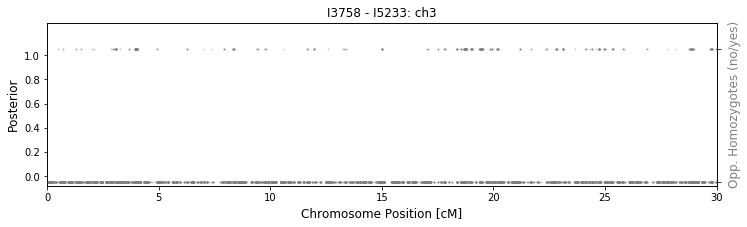

In [12]:
import h5py
from ancIBD.IO.h5_load import get_opp_homos_f


id1 = 'I3758'
id2 = 'I5233'
xlim = [0, 30]
ch = 3
f = h5py.File('AGDP.MAF5.ch3.h5', 'r')
r_vec = f['variants/MAP'][:]
o_homos, m = get_opp_homos_f(iid1=id1, iid2=id2, 
                                     f_path='AGDP.MAF5.ch', ch=ch, exact=False)
plot_posterior(morgan=r_vec, het=o_homos, het_m=m,
                       title=f'{id1} - {id2}: ch{ch}', xlim=xlim, show=True, df_ibd=[],
                       savepath=f'./fig/{id1}_{id2}_suspiciousRegion.png', xlabel="Chromosome Position [cM]")

In [ ]:
from ancIBD.IO.h5_load import get_opp_homos_f
import h5py
import pandas as pd
import itertools

ch = 3
f = h5py.File('AGDP.MAF5.tvOnly.ch3.h5', 'r')
r_vec = f['variants/MAP'][:]
iids = ['I4893', 'I4596', 'I1583', 'I2978', 'I5838', 'I1507', 'I2861', 'I2520', 'I3758', 'I5077', 'I0708', 'I5233', 'I3123']
for id1, id2 in itertools.combinations(iids, 2):
        o_homos, m = get_opp_homos_f(iid1=id1, iid2=id2, 
                                     f_path='AGDP.MAF5.tvOnly.ch', ch=ch, exact=False)
        plot_posterior(morgan=r_vec, het=o_homos, het_m=m,
                       title=f'{id1} - {id2}: ch{ch}', xlim=[], show=True, df_ibd=[],
                       savepath=f'./fig/{id1}_{id2}_tvOnly.png', xlabel="Chromosome Position [cM]")


In [ ]:
from ancIBD.IO.h5_load import get_opp_homos_f
import h5py
import pandas as pd
import itertools

ch = 3
f = h5py.File('./downsample/1240k/cov3/batch1/batch1.chr3.h5', 'r')
r_vec = f['variants/MAP'][:]
#iids = ['I4893', 'I4596', 'I1583', 'I2978', 'I5838', 'I1507', 'I2861', 'I2520', 'I3758', 'I5077', 'I0708', 'I5233', 'I3123']
iids = ['I4893', 'I4596', 'I1583', 'I2978', 'I5838', 'I1507', 'I2861', 'I2520', 'I3758', 'I0708', 'I3123']

df_ibd = pd.read_csv('./downsample/1240k/cov3/batch1/ch3.tsv', sep='\t')

for id1, id2 in itertools.combinations(iids, 2):
        o_homos, m = get_opp_homos_f(iid1=id1, iid2=id2, 
                                     f_path='./downsample/1240k/cov3/batch1/batch1.chr', ch=ch, exact=False)
        df_ibd_subset = df_ibd[((df_ibd['iid1'] == id1) & (df_ibd['iid2'] == id2)) | ((df_ibd['iid2'] == id1) & (df_ibd['iid1'] == id2))]
        plot_posterior(morgan=r_vec, het=o_homos, het_m=m,
                       title=f'{id1} - {id2}: ch{ch}', xlim=[], show=True, df_ibd=df_ibd_subset,
                       savepath=f'./downsample/1240k/cov3/batch1/fig/{id1}_{id2}.png', xlabel="Chromosome Position [cM]")
